nersc jupyter steps

in the terminal
```
module load python
conda create -n qmlhep python=3.8
source activate qmlhep
conda install ipykernel
python -m ipykernel install --user --name qmlhep
```

Install required packages. Check cuda version using `nvcc --version` (probably 11.7)

```
pip install pytorch-lightning
pip install torch_geometric
pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu117.html
pip install jax
pip install jaxlib==0.4.13+cuda11.cudnn86 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
pip install tensorcircuit
pip install qiskit
pip install matplotlib
pip install pylatexenc
pip install tabulate
```

Next time do

```
module load python
source activate qmlhep
```

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Comment this to use gpu

In [2]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelSummary
# from pytorch_lightning.loggers import WandbLogger

import jax
import jax.numpy as jnp
import tensorcircuit as tc

torch.set_float32_matmul_precision("medium")
K = tc.set_backend("jax")
print(tc.__version__)

Please first ``pip install -U cirq`` to enable related functionality in translation module
optax not installed, `optimizer` from jax backend cannot work


0.10.0


In [3]:
jax.devices()

2023-07-13 21:40:28.244871: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


### TC

In [5]:
def get_circ(nqubits, nlayers, x, weights):
    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.rx(i, theta=x[i])
    for j in range(nlayers):
        for i in range(nqubits - 1):
            c.cnot(i, i + 1)
        for i in range(nqubits):
            c.rx(i, theta=weights[2 * j, i])
            c.ry(i, theta=weights[2 * j + 1, i])
    return c

def circuit_wrapper(nqubits, nlayers):
    
    # We define the quantum function,
    # note how this function is running on jax
    def qpred(x, weights):
        circuit = get_circ(nqubits, nlayers, x, weights)
        return K.real(jnp.array([circuit.expectation_ps(z=[i]) for i in range(nqubits)]))

    # `qpred_vmap` is a jax function with vectorization capacity
    qpred_vmap = K.vmap(qpred, vectorized_argnums=0)

    # Wrap the function into pytorch form but with jax speed!
    qpred_batch = tc.interfaces.torch_interface(qpred_vmap, jit=True)
    
    return qpred_batch

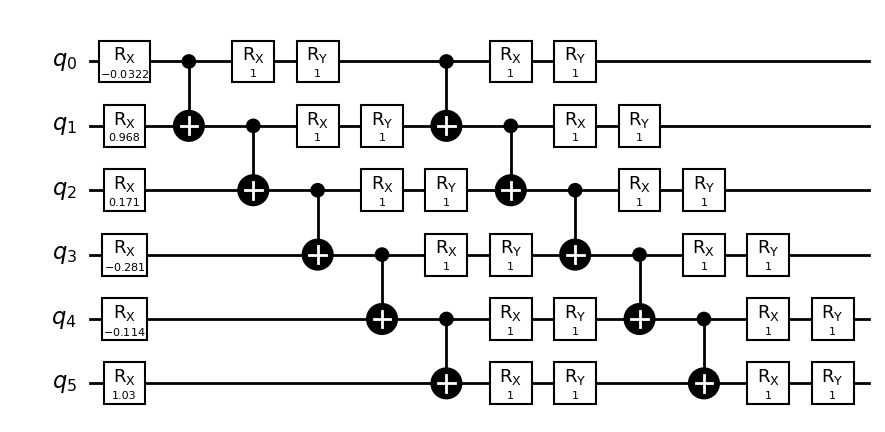

In [6]:
# Test the AD capacity of the PyTorch function
nqubits = 6
nlayers = 2
w = torch.ones([2 * nlayers, nqubits])
dummy_x = torch.randn([2, nqubits])

get_circ(nqubits, nlayers, dummy_x[0], w).draw(output='mpl', style="bw", fold=0)

In [7]:
qpred_batch = circuit_wrapper(nqubits, nlayers)

In [8]:
w.requires_grad_()
with torch.set_grad_enabled(True):
    yps = qpred_batch(dummy_x, w)
    loss = torch.sum(yps)
    loss.backward()
print(w.grad)

tensor([[ 0.0382,  0.7939,  1.2747,  1.0610,  0.2944,  1.0356],
        [-0.1863, -0.1944, -0.4800, -0.4128, -0.0397,  0.2401],
        [-0.3528, -0.0940, -0.0165, -0.0134, -0.0139, -0.0380],
        [-0.1353, -0.1483, -0.2014, -0.1988,  0.0465,  0.1186]])


In [9]:
w.shape, w.grad.shape

(torch.Size([4, 6]), torch.Size([4, 6]))

In [10]:
yps

tensor([[-0.1176, -0.1805, -0.1734, -0.1693,  0.1425,  0.1181],
        [ 0.0221, -0.2925, -0.1863, -0.1600, -0.1172,  0.0396]],
       grad_fn=<FunBackward>)

In [11]:
class QuantumNet(nn.Module):
    def __init__(self, nqubits, nlayers):
        super().__init__()
        self.q_weights = torch.nn.Parameter(torch.randn([2 * nlayers, nqubits]))
        self.qpred_batch = circuit_wrapper(nqubits, nlayers)
        
        self.nqubits = nqubits
        self.nlayers = nlayers
    
    def forward(self, inputs):
#         print("Inside quantum net", inputs.shape)
        ypred = self.qpred_batch(inputs, self.q_weights)
#         print("output of qpred", ypred.shape)
        return ypred

In [12]:
net = QuantumNet(6, 2)
out = net(dummy_x)
print(out)
print(out.shape)

tensor([[ 0.7261,  0.1317,  0.1594,  0.0111, -0.0745,  0.2600],
        [ 0.5307,  0.1184, -0.1496,  0.0037,  0.0718,  0.0582]],
       grad_fn=<FunBackward>)
torch.Size([2, 6])


In [13]:
class QGCNConv(geom_nn.GCNConv):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
        normalize: bool = True,
        bias: bool = True,
        nlayers = 1,
        **kwargs,
    ):
        super().__init__(in_channels,
                        out_channels,
                        improved,
                        cached,
                        add_self_loops,
                        normalize,
                        bias,
                        **kwargs)
        self.lin = QuantumNet(in_channels, nlayers)

In [14]:
gnn_layer_by_name = {
    "QGCN": QGCNConv,
    "GCN" : geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv
}

In [15]:
DATASET_PATH = "./data"
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="MUTAG")

In [16]:
print("Data object:", tu_dataset.data)
print("Length:", len(tu_dataset))
print(f"Average label: {tu_dataset.data.y.float().mean().item():4.2f}")

Data object: Data(x=[3371, 7], edge_index=[2, 7442], edge_attr=[7442, 4], y=[188])
Length: 188
Average label: 0.66


/home/gopald/Documents/qgnn-hep/qmlhep/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [17]:
tu_dataset.get_summary()

TUDataset (#graphs=188):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     17.9 |     39.6 |
| std        |      4.6 |     11.4 |
| min        |     10   |     20   |
| quantile25 |     14   |     28   |
| median     |     17   |     38   |
| quantile75 |     22   |     50   |
| max        |     28   |     66   |
+------------+----------+----------+

In [18]:
import torch_geometric.transforms as T

In [19]:
transform = T.Compose([T.Pad(32, mask_pad_value=True)])
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="MUTAG", transform=transform)
tu_dataset.get_summary()

TUDataset (#graphs=188):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |       32 |     1024 |
| std        |        0 |        0 |
| min        |       32 |     1024 |
| quantile25 |       32 |     1024 |
| median     |       32 |     1024 |
| quantile75 |       32 |     1024 |
| max        |       32 |     1024 |
+------------+----------+----------+

In [20]:
torch.manual_seed(42)
tu_dataset.shuffle()
split = 145
train_dataset = tu_dataset[:split]
test_dataset = tu_dataset[split:]

In [21]:
batch_size = 16
graph_train_loader = geom_data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=12)

graph_val_loader = geom_data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=12)

graph_test_loader = geom_data.DataLoader(test_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=12)

/home/gopald/Documents/qgnn-hep/qmlhep/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [22]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch[:40])

Batch: DataBatch(edge_index=[2, 16384], x=[512, 7], edge_attr=[16384, 4], y=[16], num_nodes=512, batch=[512], ptr=[17])
Labels: tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 0])
Batch indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])


In [23]:
for batch in graph_train_loader:
    print(batch)

DataBatch(edge_index=[2, 16384], x=[512, 7], edge_attr=[16384, 4], y=[16], num_nodes=512, batch=[512], ptr=[17])
DataBatch(edge_index=[2, 16384], x=[512, 7], edge_attr=[16384, 4], y=[16], num_nodes=512, batch=[512], ptr=[17])
DataBatch(edge_index=[2, 16384], x=[512, 7], edge_attr=[16384, 4], y=[16], num_nodes=512, batch=[512], ptr=[17])
DataBatch(edge_index=[2, 16384], x=[512, 7], edge_attr=[16384, 4], y=[16], num_nodes=512, batch=[512], ptr=[17])
DataBatch(edge_index=[2, 16384], x=[512, 7], edge_attr=[16384, 4], y=[16], num_nodes=512, batch=[512], ptr=[17])
DataBatch(edge_index=[2, 16384], x=[512, 7], edge_attr=[16384, 4], y=[16], num_nodes=512, batch=[512], ptr=[17])
DataBatch(edge_index=[2, 16384], x=[512, 7], edge_attr=[16384, 4], y=[16], num_nodes=512, batch=[512], ptr=[17])
DataBatch(edge_index=[2, 16384], x=[512, 7], edge_attr=[16384, 4], y=[16], num_nodes=512, batch=[512], ptr=[17])
DataBatch(edge_index=[2, 16384], x=[512, 7], edge_attr=[16384, 4], y=[16], num_nodes=512, batch=

In [24]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          nlayers=2,
                          bias=False,
                          **kwargs),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             nlayers=2,
                             bias=False,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph 
            (PyTorch geometric notation)
        """
        for idx, l in enumerate(self.layers):
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
#                 print(f'after QGCN', x.shape)
        return x 

In [25]:
class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.embed = nn.Linear(c_in, c_hidden)
        self.GNN = GNNModel(c_in=c_hidden,
                            c_hidden=c_hidden,
                            c_out=c_hidden, # Not our prediction output yet!
                            **kwargs)
        self.head = nn.Sequential(
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph 
            (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
#         print('input', x.shape)
        x = self.embed(x)
#         print('after embed', x.shape)
        x = self.GNN(x, edge_index)
#         print('after GNN', x.shape)
        x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
#         print('after pool', x.shape)
        x = self.head(x)
#         print('after head', x.shape)
        return x

In [26]:
class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.model = GraphGNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()
        self.one_cycle_max_lr = 1e-1
        self.one_cycle_total_steps = 100

    def forward(self, tdata, mode="train"):
        data = tdata

#         n_node = tdata.x.shape[0]
#         power = 1
#         while power < n_node:
#             power *= 2
#         data = T.Pad(power, mask_pad_value=True)(tdata)

#         print(data)
    
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)
        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]
        return loss, acc

    def configure_optimizers(self):
        # High lr because of small dataset and small model
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.001) 
        return optimizer
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer, max_lr=self.one_cycle_max_lr, total_steps=self.one_cycle_total_steps
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc, prog_bar=True, batch_size=batch_size)
        self.log('val_loss', loss, prog_bar=True, batch_size=batch_size)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc, on_step=False, on_epoch=True, batch_size=batch_size)

In [27]:
from time import time

CHECKPOINT_PATH = "./checkpoints"
def train_graph_classifier(model_name, num_epochs=10, **model_kwargs):
    pl.seed_everything(42)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    
    callbacks = [ModelSummary(max_depth=4), LearningRateMonitor(logging_interval='epoch')]
#     logger = WandbLogger(project='qgnn-hep')
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=callbacks,
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         log_every_n_steps=2,
#                          logger = logger,
                         max_epochs=num_epochs,
                         enable_progress_bar=True)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = GraphLevelGNN(c_in=tu_dataset.num_node_features,
                              c_out=1 if tu_dataset.num_classes==2 else tu_dataset.num_classes,
                              **model_kwargs)
        
        s = time()
        trainer.fit(model, graph_train_loader, graph_val_loader)
        e = time()
        
        model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        
    # Test best model on validation and test set
    test_result = trainer.test(model, graph_test_loader, verbose=False)
    train_result = trainer.test(model, graph_train_loader, verbose=False)
    
    result = {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']}
    return model, result, (e-s)/num_epochs

In [30]:
num_epochs = 100
model, result, avg_epoch_time = train_graph_classifier(model_name="QGCN",
                                       c_hidden=6,
                                       layer_name="QGCN",
                                       num_layers=1,
                                       num_epochs=num_epochs,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0)


Global seed set to 42
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name               | Type              | Params
---------------------------------------------------------
0 | model              | GraphGNNModel     | 79    
1 | model.embed        | Linear            | 48    
2 | model.GNN          | GNNModel          | 24    
3 | model.GNN.layers   | ModuleList        | 24    
4 | model.GNN.layers.0 | QGCNConv          | 24    
5 | model.head         | Sequential        | 7     
6 | model.head.0       | Linear            | 7     
7 | loss_module        | BCEWithLogitsLoss | 0     
---------------------------------------------------------
79        Trainable params
0         Non-traina

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing: 0it [00:00, ?it/s]

/home/gopald/Documents/qgnn-hep/qmlhep/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

In [31]:
print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")
print(f"time: {avg_epoch_time*num_epochs}")
print(f"Avg time per epoch: {avg_epoch_time}")

Train performance: 87.50%
Test performance:  80.49%
time: 108.01230621337892
Avg time per epoch: 1.0801230621337892


10 epochs only (cpu)

| num qubits  | avg epoch time (cpu)  | avg epoch time(gpu) |
|---|---|---|
| 6  | 2.04  | 3.57  |
| 10  | 3.87  | 4.05  |
| 15  |  49.94 | -  | 
|   |   |   |
|   |   |   |
|   |   |   |
|   |   |   |

In [42]:
# import wandb

In [39]:
# wandb.finish()